# Attention-R&D

Ok, so I had tried some R&D before with attention models, but I was getting caught up on some of the technical details.

But in the meantime, there was an attention model example uploaded to the keras repo, so I decided to use *this* as a starting point for future studies! 

This example had a model coded up from the [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) paper, so I decided to start by just start from here, since I thought I could then iterate later!

However, this model is quite a bit more complicated than the previous RNN that I've been using, so if I do see a lot of improvements, I'll need to take a step back and study where these improvements are coming from, i.e, by
1. Using a bidirectinal encoder for the track encoding
2. Using a GRU instead of an LSTM for the recurrent layers
3. Just having more trainable parameters

But also, since it's a more complicated model, it also will be more susceptible to overfitting, so it's unclear at the onset whether this model will yield improved performance or not.

*Once I have a nice model, to test if it's learning the track ordering.* To test, this I could:
1. Train two models for the standard architecture of the RNN
    - One with my standard $s_{d0}$ sort
    - And another with a scrambled sort
2. Train an attention model with a TimeDistributedDense MLP (like 13 -> 25) before the RNN 
    - With the standard $s_{d0}$ sort
    - With the scrambled sort

If these models are training appropriately, I can use the activations of the attention mechanism to look at which tracks it's attending to inside of the jet!


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Load in the data

I'm going to use the 13 track features that seemed to work from before.

In [2]:
dataFile = '../data/mc16d'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_4trkClasses.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X_te = f['X_test'][:]
y_te = f['y_test'][:]
y_trk_te = f['y_trk_test'][:].astype(int)
ix_te = f['ix_test'][:]

f.close()

In [3]:
_, nTrks, nFeatures = X_te.shape

### Load in the weights

Ok, so I haven't put this functionality inside `trainNet.py` yet, so I'll load them in here.

**TO DO:** Fix at *which* epoch the weights get saved!!!

In [4]:
modelDir = "../models/mc16d"
m = NMT(loadModel=True, modelDir=modelDir,
        nFeatures=nFeatures, dataTag=dataTag,encUnits=25)

Initialize method from myModel()
Loading weights for previously trained model


acc
loss
val_acc
val_loss


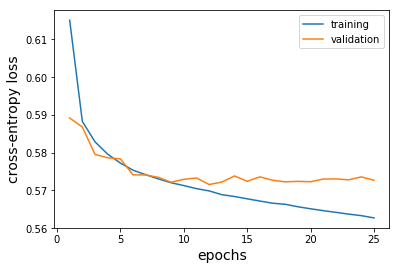

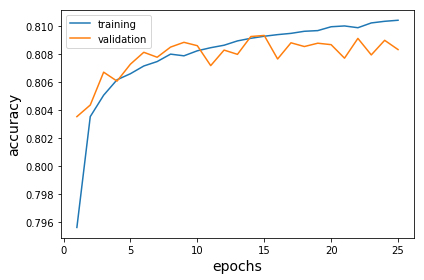

In [5]:
trainingMetrics(m.modelName)

I'm super surprised it didn't stop earlier, because I thought the patience before stopping was 25, and it seems like the val loss and accuracy stopped improving after the $5^{th}$ epcoh.

In my training code, I thought it was monitoring the validation accuracy, but based on the print statements, it looks like it was monitoring the `val_loss`.

Yeah, the val_loss doesn't improve since epoch 11 (where it was 0.57152), I can't figure out why it kept training for so long??? 


In [6]:
leffs, ceffs, beffs = [], [], []

leff, ceff, beff = sigBkgEff(m, X_te, y_te, ix_te)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [7]:
labels = ['NMT model','standard rnn']

In [8]:
btagROC(beffs, leffs, ceffs, labels)

../plottingFcts.py:429: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


Ok, so it does about as well, without any $\alpha$ for the track loss getting coded in, seems promising!

**Plan:** I think I overlay this with a model that was trained w/o any $\alpha$

Ok, while I'm waiting for that model with the same inputs to finish training, perhaps I should c.f. with one of my other RNNs trained with the hits?

This one has the same variables, but a slightly different whitening scheme.

In [9]:
dataFile = '../data/mc16d'
vStr = 'sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_logNorm_ptfrac_dr'
dataTag = "3m_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataFile,dataTag)

f = h5py.File(f_name,"r")
    
X2 = f['X_test'][:]
y2 = f['y_test'][:]
#y_trk_te = f['y_trk_test'][:].astype(int)
ix2 = f['ix_test'][:]

f.close()

In [10]:
m_lstm = myLSTM(loadModel=True, modelDir=modelDir,
                nFeatures=nFeatures, dataTag=dataTag)

Initialize method from myModel()
Loading previously trained LSTM


In [11]:
trainingMetrics(m_lstm.modelName)

acc
loss
val_acc
val_loss


In [12]:
# leffs.pop()
# ceffs.pop()
# beffs.pop()

In [13]:
leff, ceff, beff = sigBkgEff(m_lstm, X2, y2, ix2)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

In [16]:
btagROC(beffs, leffs, ceffs, labels,'NMT_firstTry')

../plottingFcts.py:429: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


Maybe it helps a little bit, but not a lot right now.